In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, QuantileRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

In [2]:
def train_test_spitted(data, test_size=0.2):
    return train_test_split(data.drop('price', axis=1),
                            data['price'],
                            test_size=test_size,
                            random_state=0)

def to_codes(df):
    for col in df.select_dtypes('category'):
        df[col] = df[col].cat.codes
    return df

def estimate_models(models_dict, X_train, y_train, X_test, y_test):
    mape, rmse = {}, {}
    for model_name, model in models_dict.items():
        pred = model.fit(X_train, y_train).predict(X_test)
        mape[model_name] = mean_absolute_percentage_error(y_test, pred)
        rmse[model_name] = mean_squared_error(y_test, pred, squared=False)
    
    mape = pd.Series(mape, name='MAPE_score')
    rmse = pd.Series(rmse, name='RMSE_score')
    scores = pd.concat([mape, rmse], axis=1)
    
    return scores

In [3]:
data = pd.read_pickle('data_eda.csv')
print(f'Shape: {data.shape}',)
display(data.head())

Shape: (9208, 14)


,model,name,url,drive,color,price,year,mileage,city,eng_vol,hp,fuel,eng_gr,city_gr
1,camry,VII (XV50) Рестайлинг,https://auto.ru/cars/used/sale/toyota/camry/11...,передний,белый,1660000,2016,123000,Екатеринбург,2.0,150,Бензин,1,1
3,camry,VIII (XV70),https://auto.ru/cars/used/sale/toyota/camry/11...,передний,чёрный,1550000,2018,239,Москва,2.0,150,Бензин,1,3
4,camry,VII (XV50),https://auto.ru/cars/used/sale/toyota/camry/11...,передний,серый,1145000,2013,131205,Москва,2.5,181,Бензин,1,3
5,camry,VII (XV50),https://auto.ru/cars/used/sale/toyota/camry/11...,передний,серый,1095000,2012,140000,Москва,2.0,148,Бензин,1,3
6,camry,VII (XV50),https://auto.ru/cars/used/sale/toyota/camry/11...,передний,чёрный,1620000,2012,148007,Пенза,2.5,181,Бензин,1,1


#### Обучим линейную регрессию c L2 регуляризацией на сырых данных

In [4]:
X = data.drop(['eng_gr', 'city_gr'], axis=1).copy()
y = X.pop('price')
X = to_codes(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['model'], random_state=0)

baseline = Ridge()
baseline.fit(X_train, y_train)

mape_train_score = mean_absolute_percentage_error(y_train, baseline.predict(X_train))
mape_test_score = mean_absolute_percentage_error(y_test, baseline.predict(X_test))
rmse_train_score = cross_val_score(baseline, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()*-1
rmse_test_score = cross_val_score(baseline, X_test, y_test, scoring='neg_root_mean_squared_error', cv=5).mean()*-1

pd.DataFrame({
    'MAPE': [mape_train_score, mape_test_score], # Mean Absolute Percentage Error
    'RMSE': [rmse_train_score, rmse_test_score], # Root Mean Square Error
}, index=['train', 'test'])

,MAPE,RMSE
train,0.582611,454669.508394
test,0.573247,456205.479289


#### Добавим  признаки

In [5]:
def create_features(data):
    data = data.copy()
    
    # при первичном анализе было видно, что зависимость квадратичная
    data['year_sqrd'] = data['year']*data['year']
    data['mileage_sqrd'] = data['mileage']*data['mileage']
    
    # dummy признаки
    data['awd'] = (data['drive'] == 'полный')*1
    data['fwd'] = (data['drive'] == 'передний')*1
    data['rwd'] = (data['drive'] == 'задний')*1
    
    data['benzine'] = (data['fuel'] == ' Бензин')*1
    data['hybrid'] = (data['fuel'] == ' Гибрид')*1
    data['diesel'] = (data['fuel'] == ' Дизель')*1
    
    data = pd.concat([data, pd.get_dummies(data['eng_gr'], 'engGr')],
                     axis=1)
    data = pd.concat([data, pd.get_dummies(data['city_gr'], 'cityGr')],
                     axis=1)
    
    # добавим средние цен по модели и марке
    data['model_mean_prc'] = data.groupby('model')['price'].transform('median')
    data['name_mean_prc'] = data.groupby(['model','name'])['price'].transform('median')
    
    # стандартизируем
    for col in ['year_sqrd', 'mileage_sqrd', 'hp', 'model_mean_prc', 'name_mean_prc']:
        data[col] = (data[col] - data[col].mean() ) / data[col].std()
    
    
    # убираем лишние
    data.drop(['eng_vol', 'year', 'mileage', 'drive', 'city', 'fuel', 'city_gr', 'eng_gr', 'url'],
              axis=1,
              inplace=True)
    
    return data

data_fe = create_features(data)

#### Сравним результаты нескольких моделей и выберем лучшую

In [6]:
data_ = data_fe.copy()
for col in data_.select_dtypes('category'):
    data_[col] = data_[col].cat.codes

X = data_.copy()
y = X.pop('price')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
models_dict = {
    'Lasso': Lasso(max_iter=1e4, random_state=0),
    'Ridge': Ridge(max_iter=1e4, random_state=0),
    'DecisionTree': DecisionTreeRegressor(random_state=0),
    'RandomForest': RandomForestRegressor(random_state=0),
    'XGBoost': XGBRegressor(random_state=0)
}

scores = estimate_models(models_dict, X_train, y_train, X_test, y_test)
scores

,MAPE_score,RMSE_score
Lasso,0.171561,272451.280738
Ridge,0.171707,272443.209877
DecisionTree,0.026488,163699.703805
RandomForest,0.022868,132041.599350
XGBoost,0.039778,137473.786894


#### Видно, что работа с признаками уменьшила ошибку Ridge более чем в 1,5 раза.<br>Но лучшая модель - RandomForest

#### Посмотрим на размеры ошибок для каждой модели автомобилей

In [8]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
pred = model.predict(X_test)
result = data.loc[X_test.index][['model', 'name', 'price']]
result['pred'] = pred
result['error'] = (result['price'] - result['pred']).abs()
result['error_rate'] = result['error'] / result['price']
result.head()

,model,name,price,pred,error,error_rate
10864,rav_4,II (XA30) Рестайлинг,1300000,1365897.03,65897.03,0.05069
11658,rav_4,II (XA30) Рестайлинг,880000,880000.00,0.00,0.00000
9611,land_cruiser_prado,120 Series Рестайлинг,1750000,1750000.00,0.00,0.00000
7067,land_cruiser,200 Series,3000000,3000000.00,0.00,0.00000
4961,corolla,VI (E90),110000,110000.00,0.00,0.00000


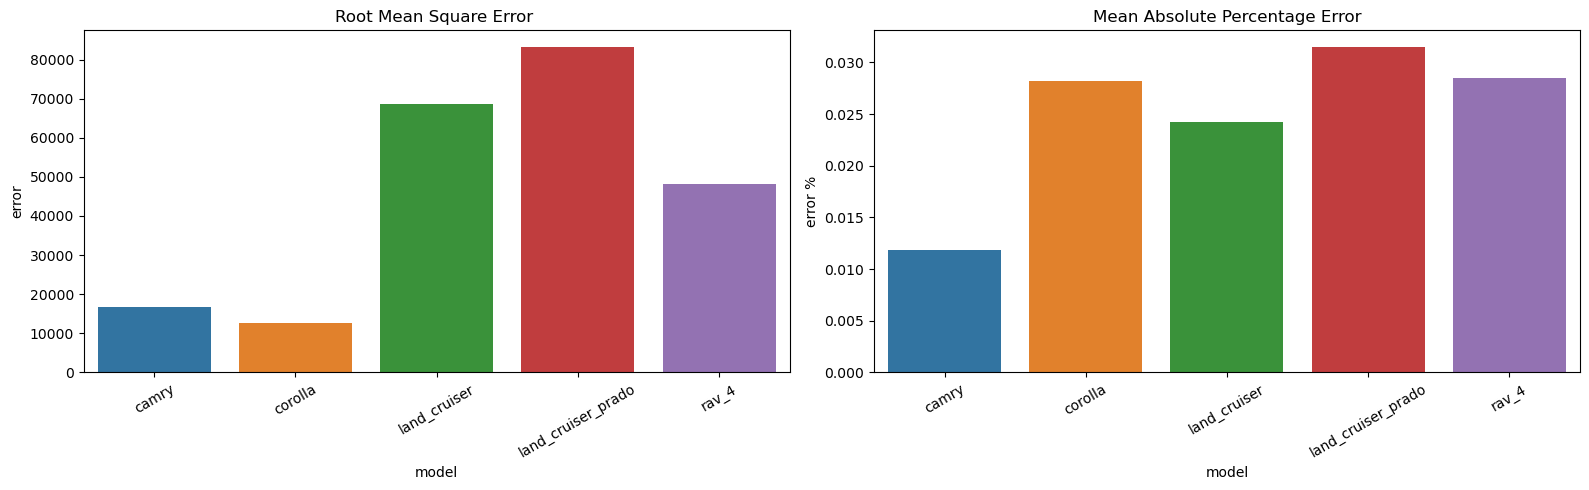

In [9]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,5))
plt.setp(ax0.xaxis.get_majorticklabels(), rotation=30)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=30)

model_error = result.groupby('model')['error'].mean()
sns.barplot(x=model_error.index, y=model_error.values, ax=ax0)
ax0.set_ylabel('error')
ax0.set_title('Root Mean Square Error ')

model_error = result.groupby('model')['error_rate'].mean()
sns.barplot(x=model_error.index, y=model_error.values, ax=ax1)
ax1.set_title('Mean Absolute Percentage Error')
ax1.set_ylabel('error %')

plt.tight_layout()
plt.show()

#### Тюнинг RandomForest

In [10]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [11]:
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(),
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [12]:
rf = RandomForestRegressor(n_estimators=1000,
                           min_samples_split=2,
                           min_samples_leaf=1,
                           max_features='sqrt',
                           max_depth=110,
                           bootstrap=True)
rf.fit(X_train, y_train)
mape_score = mean_absolute_percentage_error(y_test, rf.predict(X_test))
rmse_score = mean_squared_error(y_test, rf.predict(X_test), squared=False)
print(f'Ошибка RF после настройки параметров:\nMAPE: {mape_score}\nRMSE: {rmse_score}')

Ошибка RF после настройки параметров:
MAPE: 0.02239458388480417
RMSE: 128925.41183032059


### Настройка параметров так же смогла немного улучшить качество модели.<br>В целом модель неплохо предсказывае цену.